In [1]:
import numpy as np
import mosek
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [2]:
def disc_linear_system(A, B, delta_t):
    '''
    Discrete a linear system with implicit Euler
    x[k+1] = (I - delta_t * A)^{-1} @ x[k] + (I - delta_t * A)^{-1} @ (delta_t * B) @ u[k]
    Returns:
        Ak
        Bk
    '''
    Nx = np.shape(A)[0]
    Ix = np.identity(Nx)

    Ak = np.linalg.inv(Ix - delta_t * A)
    Bk = np.linalg.inv(Ix - delta_t * A) @ (delta_t * B)

    
    def disc_linear_fn(x, u):
        x_next = Ak @ x + Bk @ u
        
        return x_next
    
    
    return disc_linear_fn

In [3]:
def disc_linear_system(A, B, delta_t):
    '''
    Discrete a linear system with implicit Euler
    x[k+1] = (I - delta_t * A)^{-1} @ x[k] + (I - delta_t * A)^{-1} @ (delta_t * B) @ u[k]
    Returns:
        Ak
        Bk
    '''
    Nx = np.shape(A)[0]
    Ix = np.identity(Nx)

    Ak = expm(A*delta_t)
    Bk = (expm(A * delta_t) - Ix) @ np.linalg.inv(A) @ B

    
    def disc_linear_fn(x, u):
        x_next = Ak @ x + Bk @ u
        
        return x_next
    
    
    return disc_linear_fn




In [4]:
# Collect data as initial condition
def data_generation(sys, nx, nu, N, state_init = None, input_seq = None):
    # N is the length of collected data
    # Modify this for measurement functions (y = Cx)
    if input_seq is None:
        input_seq = np.random.uniform(-1,1,(nu, N))
#         input_seq = np.random.rand(nu, N)  
    N_it = np.shape(input_seq)[1] # Number of iteration
    if state_init is None:
        state_init = np.random.rand(nx,1) 
    state_seq = state_init
    xk = state_init
    for _ in range(N_it):
        uk = input_seq[:,[_]]
        state_next = sys(xk, uk)
        state_seq = np.concatenate((state_seq, state_next),axis=1)
        xk = state_next
    # Remark: the length of state_seq is larger than the input_seq by one.
    return state_seq, input_seq

In [5]:
# Construct Hankel matrix
def Hankel(sequence, L):
    n, T = np.shape(sequence)
    print(n,T)
    Hankel_matrix = np.empty((n * L, 0), dtype = float)
    for _ in range(T-L+1):
        Hankel_matrix = np.concatenate((Hankel_matrix, sequence[: , _ : _+L ].reshape(-1,1, order = 'F')),axis = 1)
    return Hankel_matrix

In [668]:
# Formulate optimization problem
def define_opt(nu, ny, Q, R, U_Hankel, Y_Hankel, T, L, n, u_ns, y_ns, ru = None, ry = None, uub = None, ulb = None, yub = None, ylb = None, lambda_alpha = None, lambda_sigma = None, eps = None):
    # Let the reference traj r be a list setpoint for input and output. To be modified, if tracking traj required.
    
    u_decision = cp.Variable(((L+n)*nu,1))
    y_decision = cp.Variable(((L+n)*ny,1))
    
    
    alpha = cp.Variable((T-(L+n)+1,1))
    
    u_init_para = cp.Parameter((n * nu, 1))
    y_init_para = cp.Parameter((n * ny, 1))
    
    
    loss_func = 0
    for _ in range(L):
        loss_func += cp.quad_form(y_decision[ ( n + _ ) * ny : ( n + _ + 1 ) * ny ,:] - np.array(ry).reshape(-1,1), Q)
        loss_func += cp.quad_form(u_decision[ ( n + _ ) * nu : ( n + _ + 1 ) * nu ,:] - np.array(ru).reshape(-1,1), R)

    if lambda_alpha is not None and eps is not None:
        loss_func += lambda_alpha * eps * cp.quad_form(alpha, np.eye(T-(L+n)+1))
        
    if lambda_sigma is not None and eps is not None:
        sigma = cp.Variable(((L+n)*ny,1))
        loss_func += lambda_sigma * cp.quad_form(sigma, np.eye((L+n)*ny))
        
    obj = cp.Minimize(loss_func)
    # Define constraints
    constraint = []
    
    constraint += [ u_decision == U_Hankel @ alpha ]
    if lambda_sigma is not None and eps is not None:
        constraint += [ y_decision + sigma == Y_Hankel @ alpha ]
#         for i in range(L):
#             constraint += [ cp.norm_inf(sigma[(n+i) * ny, (n+i+1) * ny:]) <= eps * (1+ cp.norm1(alpha))] # this type of constriants can not be defined in cvxpy
    else:
        constraint += [ y_decision == Y_Hankel @ alpha ]
    constraint += [ u_decision[: n * nu] == u_init_para ]
    constraint += [ y_decision[: n * ny] == y_init_para ]
    constraint += [ u_decision[- n * nu :] == u_ns ]
    constraint += [ y_decision[- n * ny :] == y_ns ]
    
    if uub is not None:
        for _ in range(L):
            constraint += [u_decision[ ( n + _ ) * nu : ( n + _ + 1 ) * nu, : ] <= uub]
    
    if ulb is not None:
        for _ in range(L):
            constraint += [u_decision[ ( n + _ ) * nu : ( n + _ + 1 ) * nu, : ] >= ulb]

    if yub is not None:
        for _ in range(L):
            constraint += [y_decision[ ( n + _ ) * ny : ( n + _ + 1 ) * ny ,:] <= yub]
            
    if ylb is not None:
        for _ in range(L):
            constraint += [y_decision[ ( n + _ ) * ny : ( n + _ + 1 ) * ny ,:] >= ylb]
            
    prob = cp.Problem(obj,constraint)
    
    return prob, alpha, u_init_para, y_init_para, u_decision, y_decision

In [383]:
# Simulation
def sim(opt_prob, sys, C, N_sim, delta_t, alpha, n, nu, ny, u_init, y_init, u_init_para, y_init_para, u_decision, y_decision, x_init, input_Hankel, r = None):
    # Generally, u_init and y_init are sequences, and x_init is the corresponding initial state of the last element in sequences
    t0 = 0
    xk = x_init
    uk = 0
    t = t0
    h = delta_t

    x_list = []
    x_list += xk.flatten().tolist()
    u_list = []

    # N_sample_max
    for i in range(N_sim):
        u_init_para.value = u_init
        y_init_para.value = y_init
        prob.solve(solver=cp.MOSEK)
#         uk = (input_Hankel @ alpha.value)[nu * n : nu * (n+1),:]
#         print("u dec",u_decision.value)
#         print("y dec",y_decision.value)
        uk = u_decision.value[nu * n : nu * (n+1),:]
        print(uk,xk)
        u_list += uk.flatten().tolist()
        x_kp1 = sys(xk, uk)
        xk = x_kp1
        yk = C @ xk
        u_init = np.concatenate(( u_init[nu:,:], uk ), axis = 0 )
        y_init = np.concatenate(( y_init[ny:,:], yk ), axis = 0 )
        x_list += xk.flatten().tolist()

    return x_list, u_list

### First case study, Mass spring system 

case 1: full state observation

1. larger prediction horizon required than DeePC; otherwise not stable.
2. Higher cost, since terminal constraints imposed.
3. Both methods fails with random input and output sequences in small value -> multiply 10

In [384]:
m = 2  # [kg]
k1 = 3  # [N/m]
k2 = 2  # [N/m]

A = np.array([[0, 1], [-k2 / m, -k1 / m]])
B = np.array([[0], [1 / m]])


Q = np.diag([10, 1])
R = np.diag([1])


dt = 0.1
disc_sys_fn = disc_linear_system(A,B, dt)
nx = 2
nu = 1


n = 1
L = 15
T = (nu + 1) * (n + L + nx) - 1
T = 200
state_seq, input_seq = data_generation(disc_sys_fn, nx, nu, T)

state_init = np.array([[5],[0]])
y_init_seq, u_init_seq = data_generation(disc_sys_fn, nx, nu, n, state_init = state_init)

In [385]:
state_Hankel = Hankel(state_seq[:,:-1], L+n)
input_Hankel = Hankel(input_seq, L+n)

2 200
1 200


In [386]:
y_init = y_init_seq[:,:-1].reshape(-1,1, order = 'F')
u_init = u_init_seq.reshape(-1,1, order = 'F')

u_ns = np.array([[0]])  # terminal equalibrium constraints
y_ns = np.array([[0],[0]])

In [387]:
ru = [0]
ry = [0,0]

In [388]:
prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, nx, Q, R, input_Hankel, state_Hankel, T, L, n, u_ns, y_ns, ru = ru, ry = ry)

In [389]:
u_init

array([[-0.24554863]])

In [390]:
y_init

array([[5.],
       [0.]])

In [391]:
u_init_para.value = u_init
# u_init_para.value = np.array([[6.19632452]])
y_init_para.value = y_init
prob.solve(solver=cp.MOSEK,verbose=True)
input_Hankel @ alpha.value 



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 263             
  Cones                  : 30              
  Scalar variables       : 159             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 263             
  Cones                  : 30              
  Scalar variables       : 159             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 78
Optimizer  - Cones                  : 31
Optimizer  - Scalar variables

array([[-2.45548627e-01],
       [-2.24169888e+01],
       [-2.09274071e+01],
       [-1.92880694e+01],
       [-1.74618888e+01],
       [-1.54043914e+01],
       [-1.30637638e+01],
       [-1.03813681e+01],
       [-7.29234046e+00],
       [-3.72619935e+00],
       [ 3.92453491e-01],
       [ 5.14303853e+00],
       [ 1.06079249e+01],
       [ 1.68712294e+01],
       [ 2.40175329e+01],
       [-1.08777098e-10]])

In [392]:
state_Hankel @ alpha.value 

array([[ 4.99999997e+00],
       [ 1.54349022e-10],
       [ 4.97564027e+00],
       [-4.74915577e-01],
       [ 4.85465400e+00],
       [-1.90699344e+00],
       [ 4.60502141e+00],
       [-3.05285332e+00],
       [ 4.25424463e+00],
       [-3.93478965e+00],
       [ 3.82771635e+00],
       [-4.57272112e+00],
       [ 3.34896763e+00],
       [-4.98399437e+00],
       [ 2.83993270e+00],
       [-5.18324108e+00],
       [ 2.32122445e+00],
       [-5.18230407e+00],
       [ 1.81241405e+00],
       [-4.99022728e+00],
       [ 1.33230875e+00],
       [-4.61330131e+00],
       [ 8.99222469e-01],
       [-4.05516066e+00],
       [ 5.31233909e-01],
       [-3.31693357e+00],
       [ 2.46427057e-01],
       [-2.39744396e+00],
       [ 6.31089321e-02],
       [-1.29346227e+00],
       [-6.31131106e-10],
       [ 1.27354576e-09]])

In [17]:
C = np.identity(nx)
N_sim = 100
ny = nx
# x_init = y_init[-(nx):,:]
x_init = y_init_seq[:,[-1]]

In [18]:
x_init

array([[ 4.97675799],
       [-0.45312518]])

In [19]:
x_list, u_list = sim(prob, disc_sys_fn, C, N_sim, dt, alpha, n, nu, ny, u_init, y_init, u_init_para, y_init_para, u_decision, y_decision, x_init, input_Hankel)

[[-22.48862574]] [[ 4.97675799]
 [-0.45312518]]
[[-12.62459041]] [[ 4.8576162 ]
 [-1.89176107]]
[[-10.77423066]] [[ 4.62912235]
 [-2.65522278]]
[[-8.07061708]] [[ 4.33533639]
 [-3.20193375]]
[[-6.00905495]] [[ 3.99869174]
 [-3.51746185]]
[[-4.27212245]] [[ 3.63929786]
 [-3.66084265]]
[[-2.86200752]] [[ 3.27245031]
 [-3.66977222]]
[[-1.72803293]] [[ 2.90987203]
 [-3.57804479]]
[[-0.83245421]] [[ 2.56021775]
 [-3.41333219]]
[[-0.13927813]] [[ 2.22962541]
 [-3.1983794 ]]
[[0.38366855]] [[ 1.92218075]
 [-2.95156093]]
[[0.76507826]] [[ 1.64032313]
 [-2.68749619]]
[[1.0302397]] [[ 1.3851932 ]
 [-2.41759828]]
[[1.2012128]] [[ 1.15692825]
 [-2.15057242]]
[[1.29704994]] [[ 0.95491034]
 [-1.89286209]]
[[1.33403432]] [[ 0.7779724 ]
 [-1.64904364]]
[[1.32594743]] [[ 0.62456737]
 [-1.42217231]]
[[1.2843175]] [[ 0.49290507]
 [-1.21408172]]
[[1.21865427]] [[ 0.38106127]
 [-1.02564143]]
[[1.13680126]] [[ 0.28706287]
 [-0.85697678]]
[[1.04498469]] [[ 0.20895317]
 [-0.70764855]]
[[0.94818053]] [[ 0.1448

In [20]:
x_init

array([[ 4.97675799],
       [-0.45312518]])

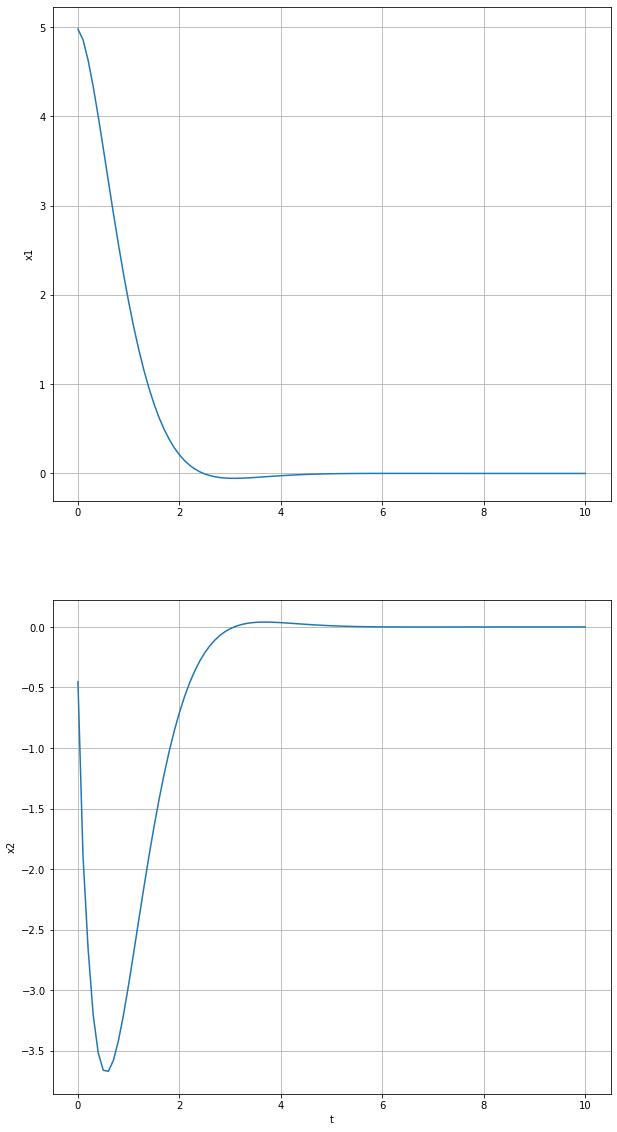

In [21]:
delta_t = dt
n = nx

x_traj = x_list

Nt = np.shape(x_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    x_traj_temp = x_traj[i::n]
    plt.plot(t_plot, x_traj_temp)
    plt.ylabel('x' + str(i + 1))

plt.xlabel('t')
plt.show()

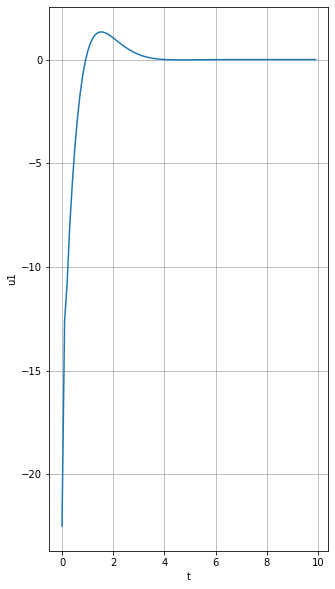

In [22]:
delta_t = dt
n = nu

u_traj = u_list

Nt = np.shape(u_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(5, 10))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    u_traj_temp = u_traj[i::n]
    plt.plot(t_plot, u_traj_temp)
    plt.ylabel('u' + str(i + 1))

plt.xlabel('t')
plt.show()

Case 2: Only observe the position of the mass

1. Set $u^s = 1$ and $y^s = 0$, the simulated stable state is [1.06351793, 0.53228785] and input [0.00174959]

In [548]:
m = 2  # [kg]
k1 = 3  # [N/m]
k2 = 2  # [N/m]

A = np.array([[0, 1], [-k2 / m, -k1 / m]])
B = np.array([[0], [1 / m]])
C = np.array([[1,0]])

Q = np.diag([10])
R = np.diag([1])


dt = 0.1
disc_sys_fn = disc_linear_system(A,B, dt)
nx = 2
ny = 1
nu = 1


n = 2
L = 15
T = (nu + 1) * (n + L + nx) - 1
T = 200
state_seq, input_seq = data_generation(disc_sys_fn, nx, nu, T)
output_seq = C @ state_seq

input_Hankel = Hankel(input_seq, L+n)
state_Hankel = Hankel(state_seq[:,:-1], L+n)
output_Hankel = Hankel(output_seq[:,:-1], L+n)



state_init = np.array([[5],[0]])
x_init_seq, u_init_seq = data_generation(disc_sys_fn, nx, nu, n, state_init = state_init)
y_init_seq = C @ x_init_seq


y_init = y_init_seq[:,:-1].reshape(-1,1, order = 'F')
u_init = u_init_seq.reshape(-1,1, order = 'F')

u_ns = np.array([[0]])  # terminal equalibrium constraints
# u_ns = np.array([[1]])
y_ns = np.array([[0]])

ru = [0]
ry = [0]
# r = [0,1]
prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, T, L, n, u_ns, y_ns, ru = ru, ry = ry)
u_init
y_init

1 200
2 200
1 200


array([[5.        ],
       [4.97562189]])

In [549]:
u_init_para.value = u_init
# u_init_para.value = np.array([[6.19632452]])
y_init_para.value = y_init
prob.solve(solver=cp.MOSEK,verbose=True)
input_Hankel @ alpha.value 



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 248             
  Cones                  : 30              
  Scalar variables       : 132             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 248             
  Cones                  : 30              
  Scalar variables       : 132             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 64
Optimizer  - Cones                  : 31
Optimizer  - Scalar variables

array([[-2.53294786e-01],
       [ 9.19693420e-01],
       [-2.48541991e+01],
       [-2.31368990e+01],
       [-2.11407765e+01],
       [-1.88235912e+01],
       [-1.61351085e+01],
       [-1.30176401e+01],
       [-9.40667439e+00],
       [-5.23209258e+00],
       [-4.19070569e-01],
       [ 5.11065660e+00],
       [ 1.14372382e+01],
       [ 1.86408926e+01],
       [ 2.67995739e+01],
       [-1.38989646e-08],
       [-1.06496216e-08]])

In [550]:
N_sim = 100
# x_init = y_init[-(nx):,:]
x_init = x_init_seq[:,[-1]]

In [551]:
x_init

array([[ 4.91008743],
       [-0.82556559]])

In [552]:
x_list, u_list = sim(prob, disc_sys_fn, C, N_sim, dt, alpha, n, nu, ny, u_init, y_init, u_init_para, y_init_para, u_decision, y_decision, x_init, input_Hankel)

[[-24.8541991]] [[ 4.91008743]
 [-0.82556559]]
[[-13.13369687]] [[ 4.75111058]
 [-2.31411033]]
[[-10.22198733]] [[ 4.48275812]
 [-3.03055678]]
[[-8.17638853]] [[ 4.15618518]
 [-3.48412172]]
[[-5.78430226]] [[ 3.79398022]
 [-3.74736122]]
[[-3.87969828]] [[ 3.41478094]
 [-3.82828281]]
[[-2.4144272]] [[ 3.0344112 ]
 [-3.77412753]]
[[-1.24945978]] [[ 2.66435456]
 [-3.62457754]]
[[-0.34636667]] [[ 2.31269171]
 [-3.40822824]]
[[0.3306697]] [[ 1.98490529]
 [-3.14853035]]
[[0.82184972]] [[ 1.684363  ]
 [-2.86441007]]
[[1.16156373]] [[ 1.41275753]
 [-2.57052049]]
[[1.37909199]] [[ 1.17049683]
 [-2.27797018]]
[[1.49981236]] [[ 0.95702669]
 [-1.9949507 ]]
[[1.54538482]] [[ 0.77109647]
 [-1.72724783]]
[[1.53400663]] [[ 0.61097658]
 [-1.4786953 ]]
[[1.48080545]] [[ 0.47463353]
 [-1.25157164]]
[[1.39820184]] [[ 0.35986822]
 [-1.04693796]]
[[1.29625189]] [[ 0.26442315]
 [-0.86492317]]
[[1.18296403]] [[ 0.18606354]
 [-0.7049622 ]]
[[1.06457206]] [[ 0.12263664]
 [-0.56599287]]
[[0.94595674]] [[ 0.07211

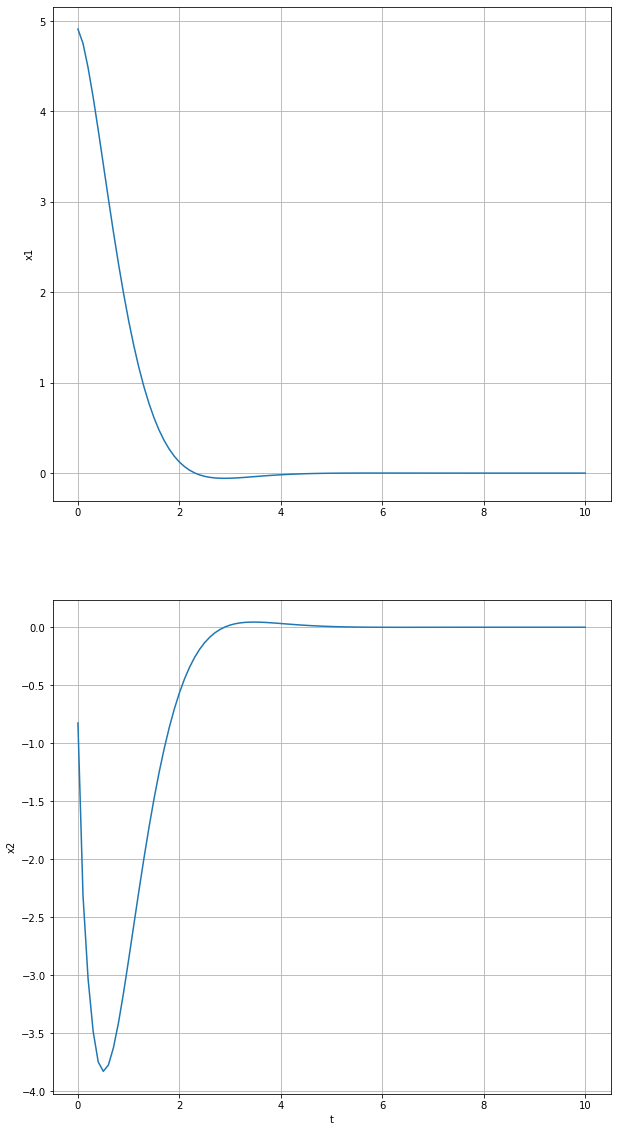

In [553]:
delta_t = dt
n = nx

x_traj = x_list

Nt = np.shape(x_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    x_traj_temp = x_traj[i::n]
    plt.plot(t_plot, x_traj_temp)
    plt.ylabel('x' + str(i + 1))

plt.xlabel('t')
plt.show()

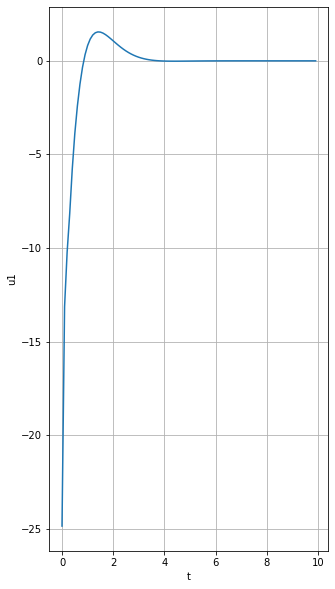

In [554]:
delta_t = dt
n = nu

u_traj = u_list

Nt = np.shape(u_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(5, 10))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    u_traj_temp = u_traj[i::n]
    plt.plot(t_plot, u_traj_temp)
    plt.ylabel('u' + str(i + 1))

plt.xlabel('t')
plt.show()

### Second case study: four tank system (case study in their paper)

It is the linear version of the nonlinear four tank system (ref: Nonlinear Model Predictive Control of a Four Tank System: An Experimental Stability Study).

$\begin{aligned} \dot{x}_{1} &=-\frac{a_{1}}{A_{1}} \sqrt{2 g x_{1}}+\frac{a_{3}}{A_{1}} \sqrt{2 g x_{3}}+\frac{\gamma_{1}}{A_{1}} u_{1} \\ \dot{x}_{2} &=-\frac{a_{2}}{A_{2}} \sqrt{2 g x_{2}}+\frac{a_{4}}{A_{2}} \sqrt{2 g x_{4}}+\frac{\gamma_{2}}{A_{2}} u_{2} \\ \dot{x}_{3} &=-\frac{a_{3}}{A_{3}} \sqrt{2 g x_{3}}+\frac{\left(1-\gamma_{2}\right)}{A_{3}} u_{2} \\ \dot{x}_{4} &=-\frac{a_{4}}{A_{4}} \sqrt{2 g x_{4}}+\frac{\left(1-\gamma_{1}\right)}{A_{4}} u_{1} \end{aligned}$

Linearized version (ref: Data-Driven Model Predictive Control with Stability and Robustness Guarantees)

$ x_{k+1} =\left[\begin{array}{cccc}0.921 & 0 & 0.041 & 0 \\ 0 & 0.918 & 0 & 0.033 \\ 0 & 0 & 0.924 & 0 \\ 0 & 0 & 0 & 0.937\end{array}\right] x_{k} +\left[\begin{array}{cc}0.017 & 0.001 \\ 0.001 & 0.023 \\ 0 & 0.061 \\ 0.072 & 0\end{array}\right] u_{k}$

$y_{k}=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0\end{array}\right] x_{k}$

set point: $\left(u^{s}, y^{s}\right)=\left(\left[\begin{array}{l}1 \\ 1\end{array}\right],\left[\begin{array}{l}0.65 \\ 0.77\end{array}\right]\right)$

1. Why simulation not stable?

In [507]:
def disc_four_tank(x, u):
    A = np.array([[0.921,  0, 0.041, 0], [0, 0.918, 0, 0.033], [0, 0, 0.924, 0], [0, 0, 0, 0.937]])
    B = np.array([[0.017, 0.001], [0.001, 0.023], [0, 0.061], [0.072, 0]])
    x_next = A@x + B@u

    return x_next

In [854]:
A = np.array([[0.921,  0, 0.041, 0], [0, 0.918, 0, 0.033], [0, 0, 0.924, 0], [0, 0, 0, 0.937]])
B = np.array([[0.017, 0.001], [0.001, 0.023], [0, 0.061], [0.072, 0]])
C = np.array([[1,0,0,0],[0,1,0,0]])




# disc_sys_fn = disc_linear_fn
nx = 4
nu = 2
ny = 2

Q = np.diag([3] * ny)
R = np.diag([1e-4] * nu)

dt = 0.1

n = 1
L = 30
# T = (nu + 1) * (n + L + nx) - 1
T = 400

u_ns = np.array([[1,1]* n]).reshape(-1,1)  # terminal equalibrium constraints
y_ns = np.array([[0.65,0.77]*n]).reshape(-1,1)
y_ns = np.array([[0.64440373,0.75261324]*n]).reshape(-1,1)
# state_init = np.array([[0.1],[0.1],[0.2],[0.2]])
state_init = np.array([[0.4],[0.4],[0],[0]])

# state_seq, input_seq = data_generation(disc_four_tank, nx, nu, T, state_init = state_init)
state_seq, input_seq = data_generation(disc_four_tank, nx, nu, T)

output_seq = C @ state_seq

In [855]:
state_seq

array([[ 0.00503702,  0.02095778,  0.03916001, ..., -0.04097407,
        -0.03353221, -0.01666421],
       [ 0.14858537,  0.13941897,  0.14112985, ..., -0.04389589,
        -0.04522896, -0.02911212],
       [ 0.39415081,  0.31917338,  0.27879077, ...,  0.05884376,
         0.06821661,  0.11918124],
       [ 0.60425336,  0.56998262,  0.56387383, ..., -0.31045009,
        -0.28426201, -0.22187617]])

In [856]:
state_Hankel = Hankel(state_seq[:,:-1], L+n)
output_Hankel = Hankel(output_seq[:,:-1], L+n)
input_Hankel = Hankel(input_seq, L+n)

4 400
2 400
2 400


In [857]:
x_init_seq, u_init_seq = data_generation(disc_four_tank, nx, nu, n, state_init = state_init)

In [858]:
x_init_seq

array([[ 0.4       ,  0.37946404],
       [ 0.4       ,  0.36749979],
       [ 0.        , -0.00093338],
       [ 0.        ,  0.04692427]])

In [859]:
y_init_seq = C @ x_init_seq
y_init_seq

array([[0.4       , 0.37946404],
       [0.4       , 0.36749979]])

In [860]:
y_init = y_init_seq[:,:-1].reshape(-1,1, order = 'F')
# x_init = x_init_seq[:,:-1].reshape(-1,1, order = 'F')
x_init = x_init_seq[:,-1].reshape(-1,1, order = 'F')
u_init = u_init_seq.reshape(-1,1, order = 'F')
x_init

array([[ 0.37946404],
       [ 0.36749979],
       [-0.00093338],
       [ 0.04692427]])

In [861]:
y_init

array([[0.4],
       [0.4]])

In [862]:
u_init

array([[ 0.65172601],
       [-0.01530137]])

In [863]:
ru = [1,1]
ry = [0.64440373,0.75261324]

In [864]:
lambda_alpha = 600
lambda_sigma = 1000
eps = 0.002

In [865]:
# prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, T, L, n, u_ns, y_ns, r = r, lambda_alpha = lambda_alpha, lambda_sigma=lambda_sigma, eps = eps)
prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, T, L, n, u_ns, y_ns, ru = ru, ry = ry, lambda_alpha = lambda_alpha, eps = eps)
# prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, T, L, n, u_ns, y_ns, ru = ru, ry = ry)

In [866]:
u_init_para.value = u_init
# u_init_para.value = np.array([[6.19632452]])
y_init_para.value = y_init
prob.solve(solver=cp.MOSEK,verbose=True)
input_Hankel @ alpha.value 
# state_Hankel @ alpha.value 



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 555             
  Cones                  : 61              
  Scalar variables       : 744             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 555             
  Cones                  : 61              
  Scalar variables       : 744             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 431
Optimizer  - Cones                  : 62
Optimizer  - Scalar variable

array([[ 0.65172601],
       [-0.01530137],
       [ 3.58789174],
       [ 4.75773558],
       [ 2.77500097],
       [ 2.75271169],
       [ 2.63506443],
       [ 1.96846044],
       [ 1.49672104],
       [ 1.38339065],
       [ 1.56098515],
       [ 1.19571761],
       [ 0.6676199 ],
       [ 1.17239634],
       [ 1.07499248],
       [ 0.46293524],
       [ 1.34611376],
       [ 0.25569594],
       [ 1.06972239],
       [ 0.14008543],
       [ 0.90258931],
       [ 0.98916887],
       [ 1.06153686],
       [ 0.26341283],
       [ 1.5556616 ],
       [ 0.47309346],
       [ 0.99451644],
       [ 0.69088983],
       [ 1.5644945 ],
       [-0.06906395],
       [ 0.61511746],
       [ 0.51925446],
       [ 0.9689159 ],
       [ 0.56806155],
       [ 1.13544159],
       [ 0.779714  ],
       [ 2.07106127],
       [ 0.66979005],
       [ 1.99050539],
       [ 0.94833859],
       [ 1.59342481],
       [ 0.33032206],
       [ 1.26012844],
       [ 0.45106315],
       [ 1.37593552],
       [ 0

In [867]:
# output_Hankel @ alpha.value 

In [868]:
# u_decision.value

In [869]:
# y_decision.value

In [870]:
# state_Hankel @ alpha.value 

In [871]:
N_sim = 100
x_list, u_list = sim(prob, disc_four_tank, C, N_sim, dt, alpha, n, nu, ny, u_init, y_init, u_init_para, y_init_para, u_decision, y_decision, x_init, input_Hankel)

[[3.58789174]
 [4.75773558]] [[ 0.37946404]
 [ 0.36749979]
 [-0.00093338]
 [ 0.04692427]]
[[2.60909016]
 [2.56545865]] [[0.41520001]
 [0.45192912]
 [0.28935942]
 [0.30229625]]
[[2.52245783]
 [2.90737042]] [[0.44118294]
 [0.48646135]
 [0.42386109]
 [0.47110608]]
[[2.19001301]
 [2.28374717]] [[0.46949694]
 [0.53151   ]
 [0.56899724]
 [0.62304336]]
[[1.96585927]
 [2.12245805]] [[0.49524954]
 [0.56320281]
 [0.66506203]
 [0.74147256]]
[[1.74487687]
 [1.83719383]] [[0.51893443]
 [0.59227116]
 [0.74398725]
 [0.83630166]]
[[1.56007002]
 [1.65883957]] [[0.53994219]
 [0.61530322]
 [0.79951305]
 [0.90924579]]
[[1.4003584 ]
 [1.48811668]] [[0.55824682]
 [0.63456685]
 [0.83993927]
 [0.96428834]]
[[1.26705161]
 [1.35872349]] [[0.57387704]
 [0.64998092]
 [0.866879  ]
 [1.00436398]]
[[1.1569013 ]
 [1.25125731]] [[0.5869814 ]
 [0.66234419]
 [0.88387833]
 [1.03231677]]
[[1.067643  ]
 [1.16799918]] [[0.59776746]
 [0.67203424]
 [0.89303027]
 [1.05057771]]
[[0.9967131 ]
 [1.10282215]] [[0.606476  ]
 [0.679

[[0.90195013]
 [0.97798768]] [[0.61722246]
 [0.69627031]
 [0.78931135]
 [1.02343367]]
[[0.90235163]
 [0.97758381]] [[0.61713479]
 [0.69634512]
 [0.78898093]
 [1.02389776]]
[[0.90276729]
 [0.97716635]] [[0.61704692]
 [0.69642023]
 [0.78865099]
 [1.02436151]]
[[0.90317497]
 [0.97675362]] [[0.61695911]
 [0.69649529]
 [0.78832067]
 [1.02482598]]


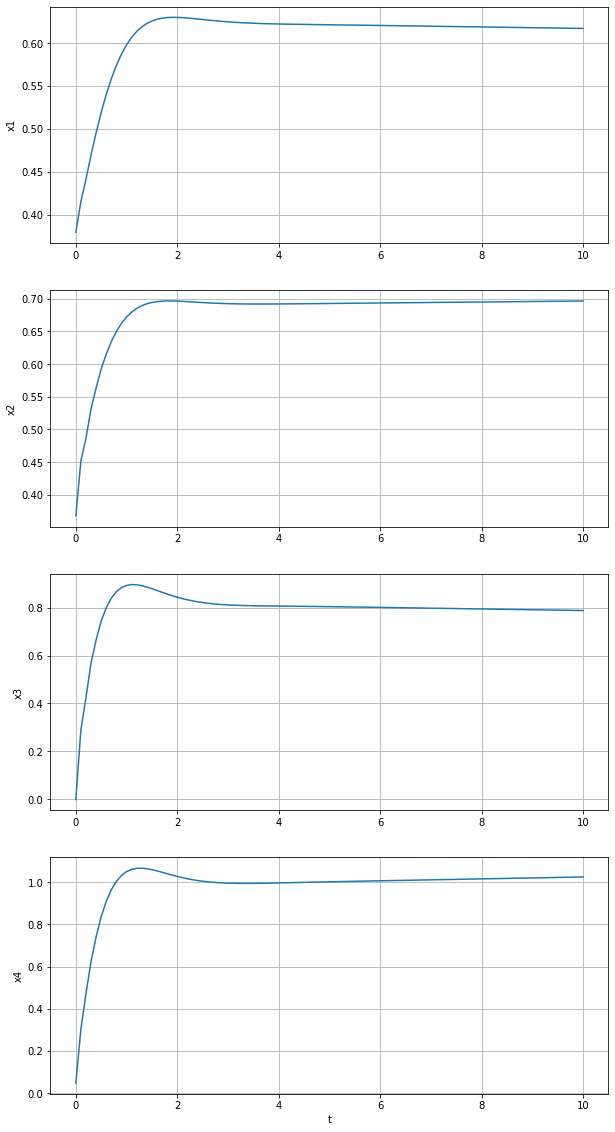

In [872]:
delta_t = dt
n = nx

x_traj = x_list

Nt = np.shape(x_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    x_traj_temp = x_traj[i::n]
    plt.plot(t_plot, x_traj_temp)
    plt.ylabel('x' + str(i + 1))

plt.xlabel('t')
plt.show()

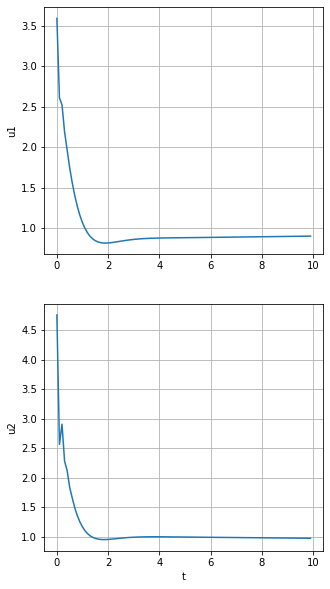

In [873]:
delta_t = dt
n = nu

u_traj = u_list

Nt = np.shape(u_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(5, 10))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    u_traj_temp = u_traj[i::n]
    plt.plot(t_plot, u_traj_temp)
    plt.ylabel('u' + str(i + 1))

plt.xlabel('t')
plt.show()

In [704]:
A = np.array([[0.921,  0, 0.041, 0], [0, 0.918, 0, 0.033], [0, 0, 0.924, 0], [0, 0, 0, 0.937]])
B = np.array([[0.017, 0.001], [0.001, 0.023], [0, 0.061], [0.072, 0]])
C = np.eye(4)




# disc_sys_fn = disc_linear_fn
nx = 4
nu = 2
ny = 4

Q = np.diag([3] * ny)
R = np.diag([1e-4] * nu)



n = 1
L = 30
# T = (nu + 1) * (n + L + nx) - 1
T = 400

u_ns = np.array([[1,1]* n]).reshape(-1,1)  # terminal equalibrium constraints
y_ns = np.array([[0.65,0.77,0,0]*n]).reshape(-1,1)
y_ns = np.array([[0.64440373,0.75261324,0.80263158,1.14285714]*n]).reshape(-1,1) 
# state_init = np.array([[0.1],[0.1],[0.2],[0.2]])
# state_init = np.array([[0.4],[0.4],[0.8],[0.8]])
state_init = np.array([0.6,0.7,0.8,1.1]).reshape(-1,1)
# state_seq, input_seq = data_generation(disc_four_tank, nx, nu, T, state_init = state_init)
state_seq, input_seq = data_generation(disc_four_tank, nx, nu, T)

output_seq = C @ state_seq

In [705]:
state_Hankel = Hankel(state_seq[:,:-1], L+n)
output_Hankel = Hankel(output_seq[:,:-1], L+n)
input_Hankel = Hankel(input_seq, L+n)

4 400
4 400
2 400


In [706]:
x_init_seq, u_init_seq = data_generation(disc_four_tank, nx, nu, n, state_init = state_init)

In [707]:
y_init_seq = C @ x_init_seq
y_init_seq

array([[0.6       , 0.58624219],
       [0.7       , 0.66769201],
       [0.8       , 0.70926652],
       [1.1       , 1.03634526]])

In [708]:
y_init = y_init_seq[:,:-1].reshape(-1,1, order = 'F')
x_init = x_init_seq[:,-1].reshape(-1,1, order = 'F')
u_init = u_init_seq.reshape(-1,1, order = 'F')
ry = [0.64440373,0.75261324,0.80263158,1.14285714]
ru = [1,1]


In [709]:
lambda_alpha = 600 # 500
lambda_sigma = 1000
eps = 0.002

In [710]:
# prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, T, L, n, u_ns, y_ns, r = r, lambda_alpha = lambda_alpha, lambda_sigma=lambda_sigma, eps = eps)
prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, T, L, n, u_ns, y_ns, ru = ru, ry = ry, lambda_alpha = lambda_alpha, eps = eps)
# prob, alpha, u_init_para, y_init_para, u_decision, y_decision = define_opt(nu, ny, Q, R, input_Hankel, output_Hankel, T, L, n, u_ns, y_ns, r = r)

In [711]:
u_init_para.value = u_init
# u_init_para.value = np.array([[6.19632452]])
y_init_para.value = y_init
prob.solve(solver=cp.MOSEK,verbose=True)



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 617             
  Cones                  : 61              
  Scalar variables       : 870             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 617             
  Cones                  : 61              
  Scalar variables       : 870             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 431
Optimizer  - Cones                  : 62
Optimizer  - Scalar variable

1.2275146006896378

In [712]:
N_sim = 100
x_list, u_list = sim(prob, disc_four_tank, C, N_sim, dt, alpha, n, nu, ny, u_init, y_init, u_init_para, y_init_para, u_decision, y_decision, x_init, input_Hankel)

[[1.96763036]
 [2.07382379]] [[0.58624219]
 [0.66769201]
 [0.70926652]
 [1.03634526]]
[[0.7139917 ]
 [0.69952914]] [[0.60453253]
 [0.69680624]
 [0.78186551]
 [1.11272489]]
[[1.63005179]
 [1.6659026 ]] [[0.60166833]
 [0.69319121]
 [0.76511501]
 [1.09403062]]
[[0.65931816]
 [0.67197722]] [[0.61488303]
 [0.71239835]
 [0.80858633]
 [1.14247042]]
[[1.45098526]
 [1.4449533 ]] [[0.6113397 ]
 [0.70779801]
 [0.78812438]
 [1.11796569]]
[[0.67260824]
 [0.7069221 ]] [[0.62146866]
 [0.72133635]
 [0.81636908]
 [1.15200479]]
[[1.34554244]
 [1.31415827]] [[0.61798503]
 [0.71713474]
 [0.79744728]
 [1.12785629]]
[[0.7070651 ]
 [0.75652404]] [[0.62604794]
 [0.72712013]
 [0.81700494]
 [1.1536804 ]]
[[1.27670048]
 [1.23024225]] [[0.62286398]
 [0.72367485]
 [0.80106053]
 [1.13190722]]
[[0.74481728]
 [0.80375565]] [[0.62943536]
 [0.73125873]
 [0.81522471]
 [1.1525195 ]]
[[1.22774582]
 [1.17290588]] [[0.62659983]
 [0.72855985]
 [0.80229672]
 [1.13353761]]
[[0.77963683]
 [0.84365181]] [[0.63203719]
 [0.7344292

[[0.99531729]
 [0.99702534]] [[0.6416757 ]
 [0.74882291]
 [0.79997652]
 [1.13589154]]
[[0.99265514]
 [0.99639805]] [[0.64169977]
 [0.74883076]
 [0.79999685]
 [1.13599322]]
[[0.99517349]
 [0.99699148]] [[0.6416769 ]
 [0.74882422]
 [0.79997737]
 [1.13589681]]
[[0.99279137]
 [0.99643025]] [[0.64169844]
 [0.74883121]
 [0.79999557]
 [1.13598781]]


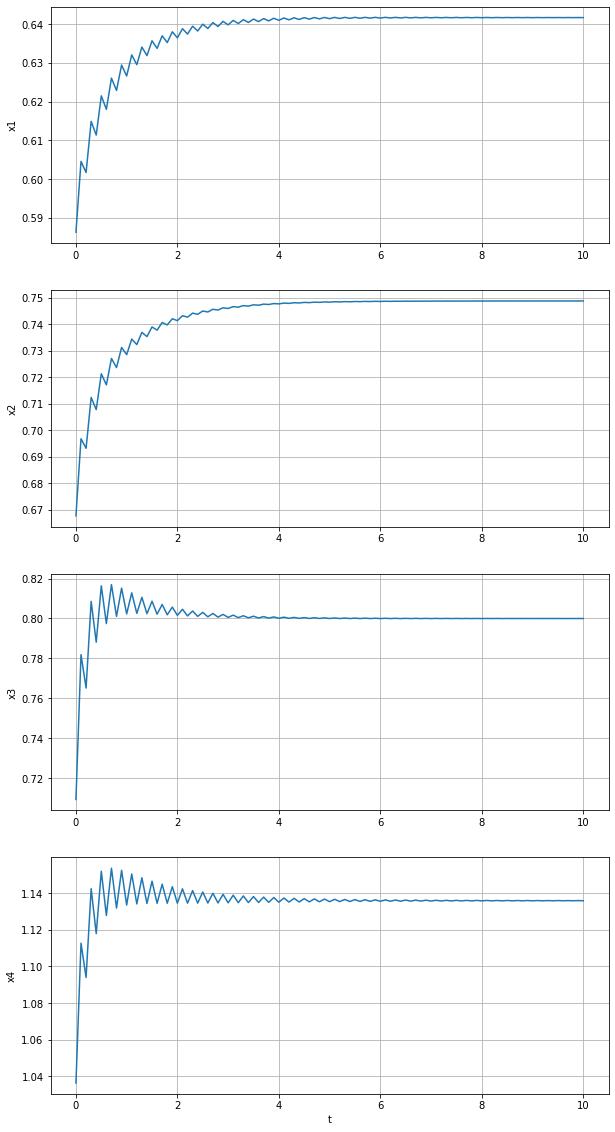

In [713]:
delta_t = dt
n = nx

x_traj = x_list

Nt = np.shape(x_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    x_traj_temp = x_traj[i::n]
    plt.plot(t_plot, x_traj_temp)
    plt.ylabel('x' + str(i + 1))

plt.xlabel('t')
plt.show()

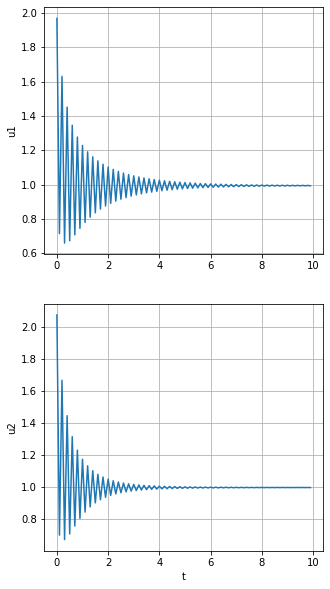

In [714]:
delta_t = dt
n = nu

u_traj = u_list

Nt = np.shape(u_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(5, 10))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    u_traj_temp = u_traj[i::n]
    plt.plot(t_plot, u_traj_temp)
    plt.ylabel('u' + str(i + 1))

plt.xlabel('t')
plt.show()